In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [2]:
df3 = pd.read_csv("C:/Users/my pc/Desktop/Capstone/cap 5/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df4 = pd.read_csv("C:/Users/my pc/Desktop/Capstone/cap 5/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df5 = pd.read_csv("C:/Users/my pc/Desktop/Capstone/cap 5/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df = pd.concat ([df3, df4, df5], axis=0, ignore_index = True)
df.isnull().sum()

month                      0
town                       0
flat_type                  0
block                      0
street_name                0
storey_range               0
floor_area_sqm             0
flat_model                 0
lease_commence_date        0
resale_price               0
remaining_lease        52203
dtype: int64

In [3]:
df['age_of_flat'] = 2024 - df['lease_commence_date']

In [4]:
df['remaining_lease'].fillna(99 - df['age_of_flat'], inplace=True)

In [5]:
def get_remaining_lease_months(remaining_lease):
    if pd.isna(remaining_lease):  # Check if the value is NaN
        return None
    if isinstance(remaining_lease, int):  # Check if the value is a float, representing years only
        return remaining_lease * 12
    try:
        years_part, months_part = remaining_lease.split(' years ')
        years = int(years_part)
        months = int(months_part.split(' months')[0])
        return years * 12 + months
    except ValueError:
        # Handle cases where the format might not exactly match the expected pattern
        try:
            # Assume format might be like "10 years" without months
            years = int(remaining_lease.split(' years')[0])
            return years * 12
        except ValueError:
            return None  # If format is incorrect or unparsable

# Apply the function to the DataFrame
df['remaining_lease_months'] = df['remaining_lease'].apply(get_remaining_lease_months)

In [6]:
def num_rooms(flat_type):
    mapping = {
        '1 ROOM': 1,
        '2 ROOM': 2,
        '3 ROOM': 3,
        '4 ROOM': 4,
        '5 ROOM': 4.5,
        'EXECUTIVE': 6,  # Assumption, can vary based on data
        'MULTI GENERATION': 5  # Assumption, can vary based on data
    }
    return mapping.get(flat_type, 0)

# Create a column for number of rooms
df['num_rooms'] = df['flat_type'].apply(num_rooms)

In [7]:
df.drop(columns=['month', 'remaining_lease', 'block', 'street_name'], inplace = True)

In [8]:
town_encoder = LabelEncoder()
flat_type_encoder = LabelEncoder()
storey_range_encoder = LabelEncoder()
flat_model_encoder = LabelEncoder()


df['town_encoded'] = town_encoder.fit_transform(df['town'])
df['flat_type_encoded'] = flat_type_encoder.fit_transform(df['flat_type'])
df['storey_range_encoded'] = storey_range_encoder.fit_transform(df['storey_range'])
df['flat_model_encoded'] = flat_model_encoder.fit_transform(df['flat_model'])

In [9]:
df.drop(columns=['town', 'flat_type', 'storey_range', 'flat_model'], inplace = True)

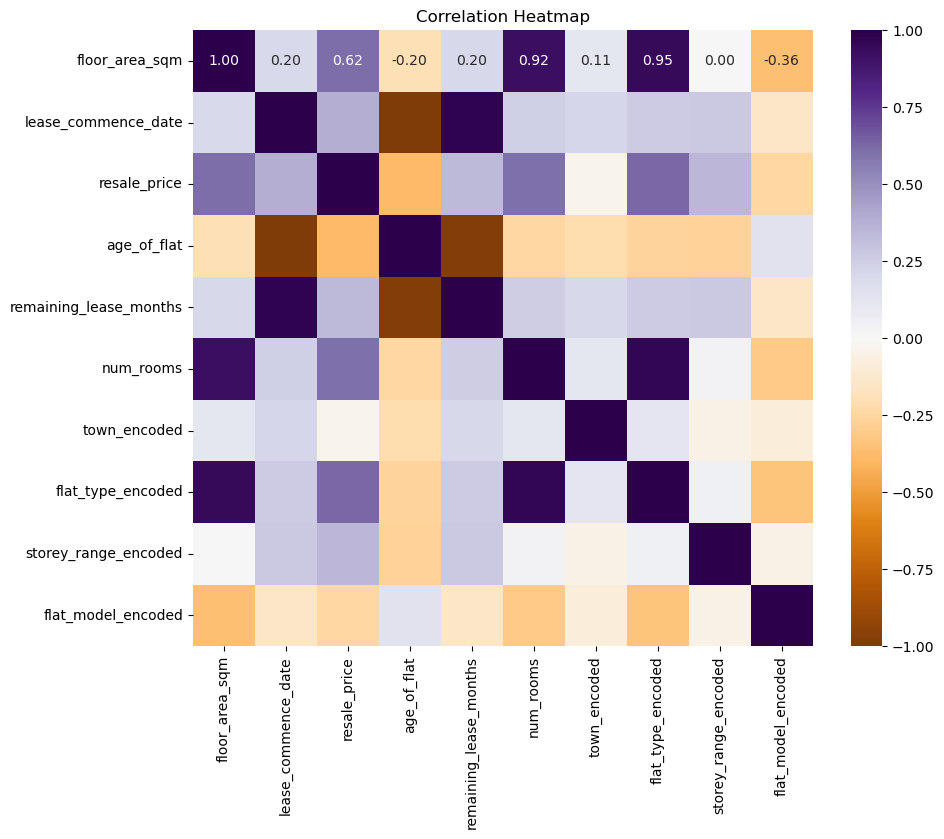

In [10]:
numerical_columns = ['floor_area_sqm', 'lease_commence_date', 'resale_price', 'age_of_flat',
                     'remaining_lease_months', 'num_rooms', 'town_encoded', 'flat_type_encoded',
                    'storey_range_encoded', 'flat_model_encoded']

# Calculate the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [11]:
X = df.drop('resale_price', axis = 1)
y = df['resale_price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Check initial data formats and shapes
print("Initial shapes:", X_train.shape, y_train.shape)

# Use a smaller subset of the data for training
X_train_small = X_train.sample(frac=0.7, random_state=42)
y_train_small = y_train.loc[X_train_small.index]  # Align with X_train_small indices

# Convert to numpy arrays and ensure 1D for y_train_small
X_train_small_array = X_train_small.to_numpy()
y_train_small_array = y_train_small.to_numpy().reshape(-1)

# Verify data shapes after conversion
print("Shapes after conversion:", X_train_small_array.shape, y_train_small_array.shape)

# Define and fit the model
rfr = RandomForestRegressor(
    n_estimators=70,
    random_state=54
)

rfr.fit(X_train_small_array, y_train_small_array)

# Save the model for later use
with open('rfr2_model.pkl', 'wb') as file:
    pickle.dump(rfr, file)

Initial shapes: (216917, 9) (216917,)
Shapes after conversion: (151842, 9) (151842,)


In [20]:
X_test_small = X_test
y_test_small = y_test.loc[X_test_small.index]  # Align with X_train_small indices

X_test_small_array = X_test_small.to_numpy()
y_test_small_array = y_test_small.to_numpy().reshape(-1)

# Predict on training and test sets
train_pred = rfr.predict(X_train_small_array)
test_pred = rfr.predict(X_test_small_array)

# Calculate regression metrics
train_mse = mean_squared_error(y_train_small_array, train_pred)
train_r2 = r2_score(y_train_small_array, train_pred)
test_mse = mean_squared_error(y_test_small_array, test_pred)
test_r2 = r2_score(y_test_small_array, test_pred)

print(f"Train MSE: {train_mse}, Train R²: {train_r2}")
print(f"Test MSE: {test_mse}, Test R²: {test_r2}")
print(math.sqrt(train_mse))
print(math.sqrt(test_mse))

Train MSE: 333298295.6939788, Train R²: 0.9871778507420569
Test MSE: 1499830340.7267408, Test R²: 0.9420462963504496
18256.45901301725
38727.64310833724


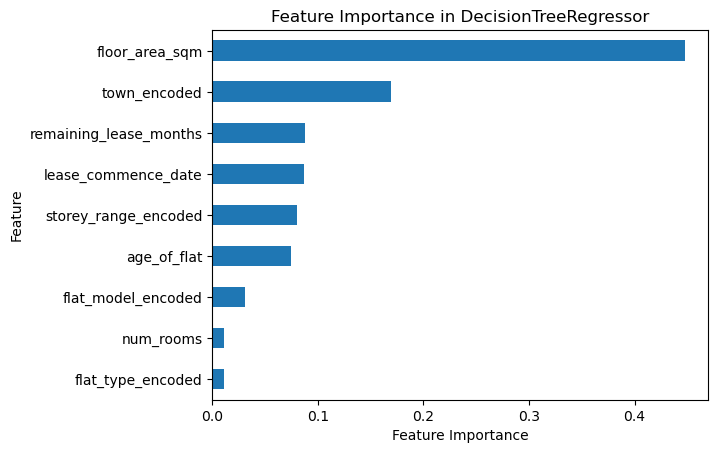

In [21]:
feature_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in DecisionTreeRegressor')
plt.show()

In [22]:
parameters = rfr.get_params()
print("Model parameters:", parameters)

Model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 70, 'n_jobs': None, 'oob_score': False, 'random_state': 54, 'verbose': 0, 'warm_start': False}


In [17]:
# Save the model and encoders
# with open('rfr2_model.pkl', 'wb') as file:
#     pickle.dump(rfr, file)
    
with open('town_encoder2.pkl', 'wb') as file:
    pickle.dump(town_encoder, file)

with open('flat_type_encoder2.pkl', 'wb') as file:
    pickle.dump(flat_type_encoder, file)

with open('storey_range_encoder2.pkl', 'wb') as file:
    pickle.dump(storey_range_encoder, file)

with open('flat_model_encoder2.pkl', 'wb') as file:
    pickle.dump(flat_model_encoder, file)


In [ ]:
param_dist = {
    'ccp_alpha': [0.065,0.07,0.075,0.08, 0.085],  
    'max_depth': [18,19,20,21,22],        
    'min_samples_split': [8,9,10,11,12], 
    'min_samples_leaf': [3,4,5,6,7],     
    'max_features': ['log2'],  
    'criterion': ['squared_error']  
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_dist, n_iter=70, cv=5, scoring='neg_mean_squared_error',
                                   random_state=0, n_jobs=2)

# Fit the model
random_search.fit(X_train_small_array, y_train_small_array)

# Print the best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(Xb_test)
test_mse1 = mean_squared_error(yb_test, y_pred)
test_r2_1 = r2_score(yb_test, y_pred)
print(math.sqrt(test_mse1))
print(test_r2_1)